<a href="https://colab.research.google.com/github/bernieee/COURSERA/blob/master/Intro_to_DL/week2/NumpyNN_(honor)_L2reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For Colab Users

In [33]:
# if you use google_colab
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week2()  # change to the week you're working on
# note on week 2: select setup_week2_v2() if you've started the course after August 13, 2018,
# otherwise call setup_week2().


--2020-07-18 12:54:49--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-07-18 12:54:49 (43.2 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


In [34]:
# set tf 1.x for colab
%tensorflow_version 1.x

### Report

#### L2-regularization

In this notebook I experimented with adding L2-regularization in neural network with great number of neurons.

At first I tried 3000 neurons in the second and the third Dense layers. I have plotted several graphs with/without L2 and with different alpha_L2 parameter. You can see training results below in the table.

You can also plot all this graphs by yourself, but it will take a lot of time, so you can just take a look at them, so run cells one by one until you see cell with first graph in 'Train loop' paragraph.

alpha_L2 | batch_size | val_acc
--- | --- | ---
0.0 | 32 | 0.9805
0.0 | 1024 | 0.9393
0.001 | 32 | 0.9762
0.001 | 1024 | 0.9052
0.005 | 32 | 0.9506
0.005 | 1024 | 0.9155
0.01 | 32 | 0.9203
0.01 | 1024 | 0.9036

As you can see, validation accuracy results do not get better with L2 regularization, and if you'll take a look on graphs you can see, that model even overfits if we use small batch size (= 32), but when we increase batch size (= 1024) overfitting decreases.

I also tried 10000 neurons and graphs are still smooth.

I have made some conclusions of these results:


1.   L2 regularization did not mitigate overfitting in this case
2.   Increasing batch size in training model with great number of neurons helps to mitigate overfitting


### Your very own neural network

In [35]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [36]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [37]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Here goes our main class: a layer that can do .forward() and .backward() passes.

In [38]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [39]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return np.maximum(0, input)
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad        

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [40]:
# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)

        # this parameter will be changing to plot new graphs
        self.alpha_L2 = 0.0


    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        """ 
        added L2 regularization

        """
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [41]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

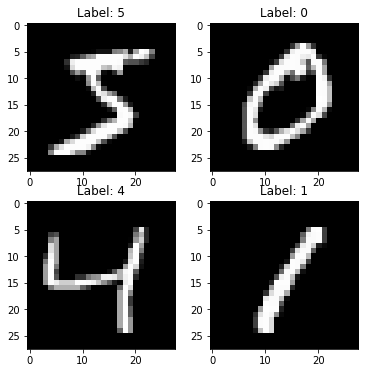

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [43]:
# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))

In [44]:
def forward(network, X):
    activations = []
    input = X
    
    for layer in network:
        activations.append(layer.forward(input))
        input = activations[-1] # last added
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)    
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for index in range(len(network))[::-1]:
        layer = network[index]
        loss_grad = layer.backward(layer_inputs[index], loss_grad)
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop neurons = 3000

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9805


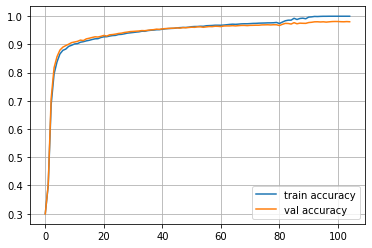

In [ ]:
# alpha_L2 = 0 --> no L2 regularization
# epochs = 24
# batchsize = 32


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.0

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Epoch 24
Train accuracy: 0.936
Val accuracy: 0.9393


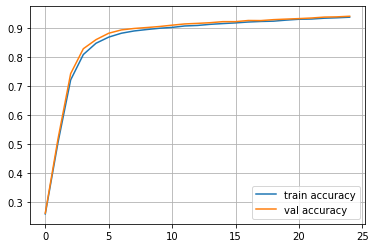

In [ ]:
# alpha_L2 = 0 --> no L2 regularization
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.0

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Epoch 24
Train accuracy: 0.98384
Val accuracy: 0.9762


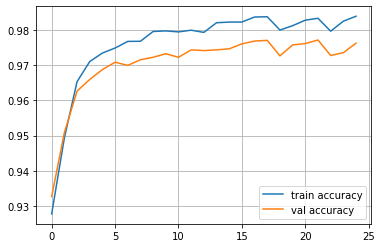

In [ ]:
# alpha_L2 = 0.001
# epochs = 24
# batchsize = 32


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.001

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.89816
Val accuracy: 0.9052


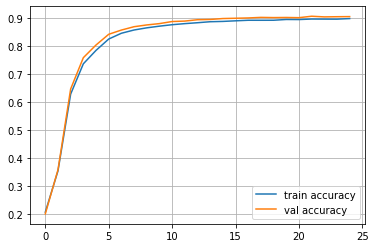

In [ ]:
# alpha_L2 = 0.001
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.001

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.94432
Val accuracy: 0.9506


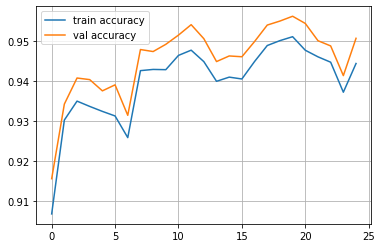

In [ ]:
# alpha_L2 = 0.005
# epochs = 24
# batchsize = 32


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.005

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.90874
Val accuracy: 0.9155


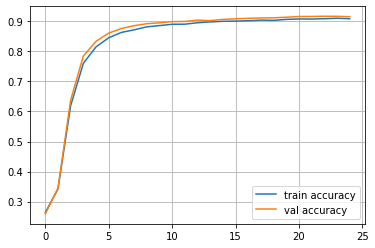

In [ ]:
# alpha_L2 = 0.005
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.005

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.9111
Val accuracy: 0.9203


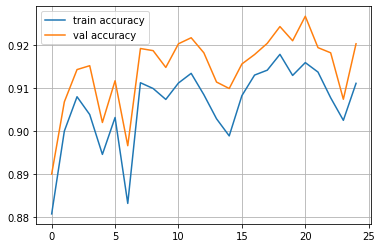

In [ ]:
# alpha_L2 = 0.01
# epochs = 24
# batchsize = 32


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.01

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.89548
Val accuracy: 0.9036


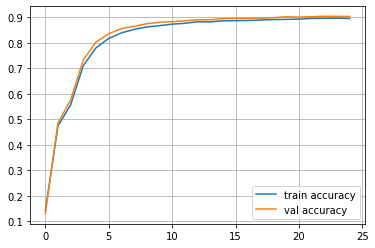

In [ ]:
# alpha_L2 = 0.01
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.01

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 3000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,3000))
network.append(ReLU())
network.append(Dense(3000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Train loop neurons = 10000

Epoch 24
Train accuracy: 0.90258
Val accuracy: 0.9103


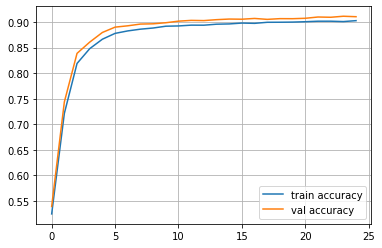

In [45]:
# alpha_L2 = 0.0
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.01

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 10000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,10000))
network.append(ReLU())
network.append(Dense(10000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.93638
Val accuracy: 0.9396


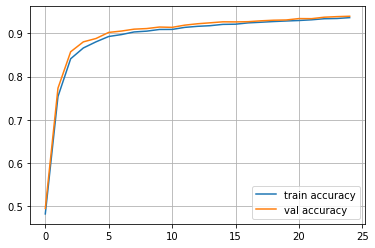

In [46]:
# alpha_L2 = 0.001
# epochs = 24
# batchsize = 1024


# L2
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
       
        alpha_init = 0.01
          
        self.weights = np.random.randn(input_units, output_units) * alpha_init
        self.biases = np.zeros(output_units)
        self.alpha_L2 = 0.001

    def forward(self, input):
        return input @ self.weights + self.biases
    
    def backward(self, input, grad_output):
        
        grad_input = grad_output @ self.weights.T 
        grad_weights = input.T @ grad_output + 2 * self.alpha_L2 * self.weights
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # SGD
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)


# number of neurons = 10000
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,10000))
network.append(ReLU())
network.append(Dense(10000,10))


from IPython.display import clear_output
train_log = []
val_log = []


for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=1024,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    